In [1]:
import os
import pickle
import datetime
import numpy as np
import array
import matplotlib.pyplot as plt
#import modape
from vam.whittaker import ws2d, ws2doptv, ws2doptvp
#from modape.utils import DateHelper, fromjulian

from osgeo import gdal
import h5py

In [2]:
def tif2array(file_path, dtype=np.uint8):
    """
    read GeoTiff and convert to numpy.ndarray.
    inputs:
        file_path (str) : file path of the input GeoTiff file
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive
    """
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

    if dataset is None:
        return None

    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=dtype)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

    #image = image[2:-2,2:-2,:]

    return image

In [3]:
# set path to data
path_dir = '/home/philipp/Desktop/time_series/georgia/modis_rest/raw/'
files = os.listdir(path_dir)

start_year = 2012
end_year = 2021

#find 
files_ndvi=[]
for n in files:
    if n[-8:] == 'NDVI.tif':
        files_ndvi.append(n)
        
files_ndvi = np.array(sorted(files_ndvi))

print(files_ndvi.size)
files_ndvi

414


array(['MOD13Q1.A2012001.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012017.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012033.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012049.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012065.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012081.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012097.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012113.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012129.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012145.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012161.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012177.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012193.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012209.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012225.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012241.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012257.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012273.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012289.250m_16_days_NDVI.tif',
       'MOD13Q1.A2012305.250m_16_days_NDVI.tif',
       'MOD13Q1.A201

### read modis tif images

In [4]:
# read images from disk
imgs = []
for i in files_ndvi[0:len(files_ndvi)]:  
    imgs.append(tif2array(path_dir + i, dtype=np.int16))

# create numpy 3D array
images = np.concatenate(imgs, axis=2)
print(images.shape)

# free RAM
del imgs

(1252, 1826, 414)


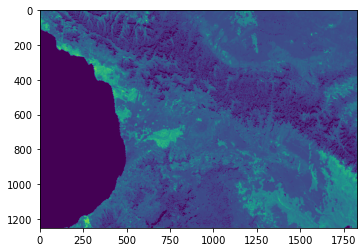

In [5]:
plt.imshow(images[:,:,1])

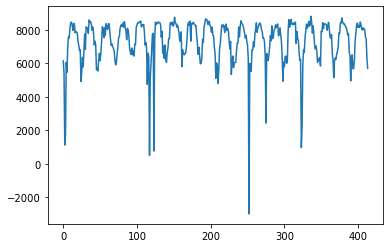

In [24]:
plt.plot(images[288,288])

### create indices

Data is stored as 16 day composit NDVI images for the two **modis** satelites **aqua** and **terra**.
The date of the 16 day mean aquisition is included in the file name:

In order to create dayly data the data has to be inserted into a array with the date

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|x|o|o|o|o|o|o|o|x|o|o|o|o|o|o|x|o|o|o|o|

1. create array with the corespnding indices
2. create 1D array of ones as a time line of one pixel corresponding to 365 days and x years
3. set values in 1D array from the observed data
4. create weights for whittaker smothing
5. whittaker smothing of one pixel

In [7]:
# create indices
idx_list = []
temp = 1
for i in range(1,10):
    
    print(2011+i)
    
    idx_src = np.arange(temp, 365*i, 16)
    idx_list.append(idx_src)
    print(idx_src)
    
    temp = temp + 365
    
temp = 9
for i in range(1,10):
    
    print(2011+i)
    
    idx_src = np.arange(temp, 365*i, 16)
    idx_list.append(idx_src)
    print(idx_src)
    
    temp = temp + 365
    
idx_src = np.concatenate(idx_list)
del idx_list

2012
[  1  17  33  49  65  81  97 113 129 145 161 177 193 209 225 241 257 273
 289 305 321 337 353]
2013
[366 382 398 414 430 446 462 478 494 510 526 542 558 574 590 606 622 638
 654 670 686 702 718]
2014
[ 731  747  763  779  795  811  827  843  859  875  891  907  923  939
  955  971  987 1003 1019 1035 1051 1067 1083]
2015
[1096 1112 1128 1144 1160 1176 1192 1208 1224 1240 1256 1272 1288 1304
 1320 1336 1352 1368 1384 1400 1416 1432 1448]
2016
[1461 1477 1493 1509 1525 1541 1557 1573 1589 1605 1621 1637 1653 1669
 1685 1701 1717 1733 1749 1765 1781 1797 1813]
2017
[1826 1842 1858 1874 1890 1906 1922 1938 1954 1970 1986 2002 2018 2034
 2050 2066 2082 2098 2114 2130 2146 2162 2178]
2018
[2191 2207 2223 2239 2255 2271 2287 2303 2319 2335 2351 2367 2383 2399
 2415 2431 2447 2463 2479 2495 2511 2527 2543]
2019
[2556 2572 2588 2604 2620 2636 2652 2668 2684 2700 2716 2732 2748 2764
 2780 2796 2812 2828 2844 2860 2876 2892 2908]
2020
[2921 2937 2953 2969 2985 3001 3017 3033 3049 3065 3081 3

In [8]:
# select one pixel
a = images[700,1010].copy()/10000

# create 1D array
whoe_year = np.ones(365*9)*-0.3

# fill data from modis
whoe_year[idx_src-1] = a

# print array
whoe_year

array([ 0.0327, -0.3   , -0.3   , ..., -0.3   , -0.3   , -0.3   ])

In [9]:
# create weights
w = np.array((whoe_year!=-0.3)*1,dtype='double')

# apply filter
z = ws2d(whoe_year,5000,w)

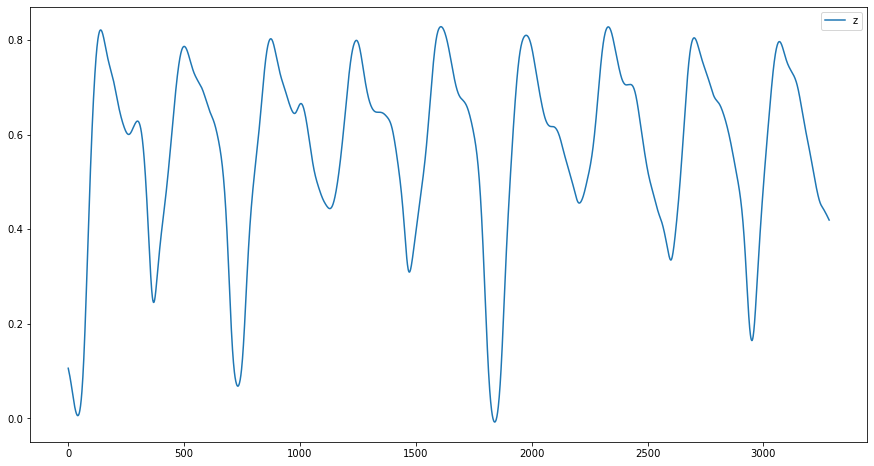

In [10]:
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z, label='z')
ax.legend()

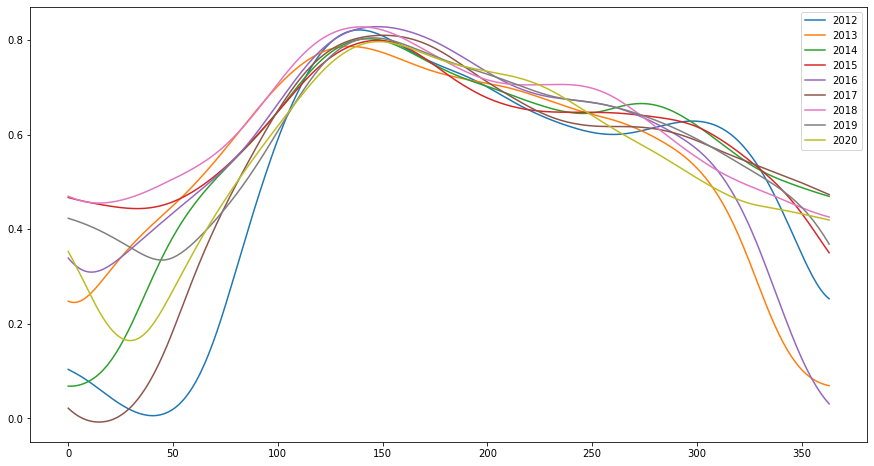

In [11]:
x = 0
y = 365

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x+1:x+y], label='2012')
ax.plot(z[x+y*1+1:x+y*2], label='2013')
ax.plot(z[x+y*2+1:x+y*3], label='2014')
ax.plot(z[x+y*3+1:x+y*4], label='2015')
ax.plot(z[x+y*4+1:x+y*5], label='2016')
ax.plot(z[x+y*5+1:x+y*6], label='2017')
ax.plot(z[x+y*6+1:x+y*7], label='2018')
ax.plot(z[x+y*7+1:x+y*8], label='2019')
ax.plot(z[x+y*8+1:x+y*9], label='2020')
ax.legend()

In [12]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

if not os.path.isfile(path_hdf5):
    print('file not found -> creating file')
    # create file
    hdf5_modis = h5py.File(path_hdf5, 'a')

In [ ]:
# create dataset
hdf5_modis.create_dataset('whittaker',\
                          (images.shape[0], images.shape[1], (end_year-start_year)*365),\
                          dtype=np.float32)

In [ ]:
def smooth_whittaker(x,y):
    
    # select one pixel
    a = images[y,x].copy()/10000

    # create 1D array
    whoe_year = np.ones(365*(end_year - start_year))*-0.3

    # fill data from modis
    whoe_year[idx_src-1] = a
    
    # create weights
    w = np.array((whoe_year!=-0.3)*1,dtype='double')

    # apply filter
    z = ws2d(whoe_year,5000,w)
    
    return z

In [ ]:
hdf5_modis[y,x,:]

In [ ]:
hdf5_modis.close()

In [ ]:
def create_hdf5(self, path_file, tile_size, dataset_size):
    self.path_hdf5 = path_file
    # cerate file
    hdf5_ds = h5py.File(path_file, 'a')
    # create dataset
    for data_type in self.data_types:
        x = hdf5_ds.create_dataset(data_type, \
        (dataset_size, tile_size, tile_size, self.data_dic[data_type]['dim']), \
        dtype=self.data_dic[data_type]['dtype'])
    hdf5_ds.close()

In [10]:
def get_time_idx(month, year):
    start_year = 2010
    end_year = 2020
    year = 

month_idx = [np.arange(0,31), np.arange(31,59), np.arange(59,90), np.arange(90,120),\
 np.arange(120,151), np.arange(151,181), np.arange(181,212), np.arange(212,243),\
 np.arange(243,273), np.arange(273,304), np.arange(304,334), np.arange(334,365)]

In [13]:
month_idx[2]

array([59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])